In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip -q breast-ultrasound-images-dataset.zip
!rm breast-ultrasound-images-dataset.zip
from google.colab import drive
drive.mount('/content/drive')
clear_output()

In [ ]:
!cd ./Dataset_BUSI_with_GT && ls -l

total 72
drwxr-xr-x 2 root root 36864 Jan 29 22:33 benign
drwxr-xr-x 2 root root 20480 Jan 29 22:33 malignant
drwxr-xr-x 2 root root 12288 Jan 29 22:33 normal


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torch import optim
from torchvision.ops import nms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import cv2
import os
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

# speed up training
#torch.backends.cudnn.benchmark = True
#torch.autograd.set_detect_anomaly(False)
#torch.autograd.profiler.profile(False)
#torch.autograd.profiler.emit_nvtx(False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
BATCH_SIZE = 4 # if > 4 CUDA runs out of memory
epochs = 50
num_classes = 3
PATH = os.path.join(os.getcwd() + '/model_weights.pth')
torch.manual_seed(1)

In [ ]:
label_to_int = {'normal': 0, 'benign': 1, 'malignant': 2}
int_to_label = {0: 'normal', 1: 'benign', 2: 'malignant'}

In [ ]:
paths = ['./Dataset_BUSI_with_GT/normal', './Dataset_BUSI_with_GT/malignant', './Dataset_BUSI_with_GT/benign']
#paths = ['./Dataset_BUSI_with_GT/malignant', './Dataset_BUSI_with_GT/benign']


imgs, masks, labels = [], [], []
for path in paths:
    p = os.listdir(path)
    for name in sorted(p):
        if name.endswith(').png'):
            imgs.append(path + '/' +name)
            labels.append(label_to_int.get(path.split('/')[-1]))
        elif name.endswith('mask.png'):
            masks.append(path + '/' + name)

data = np.array(list(zip(imgs, masks)))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.01, shuffle=True, stratify=labels, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.08, shuffle=True, stratify=y_train, random_state=1)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape

((710, 2), (62, 2), (8, 2))

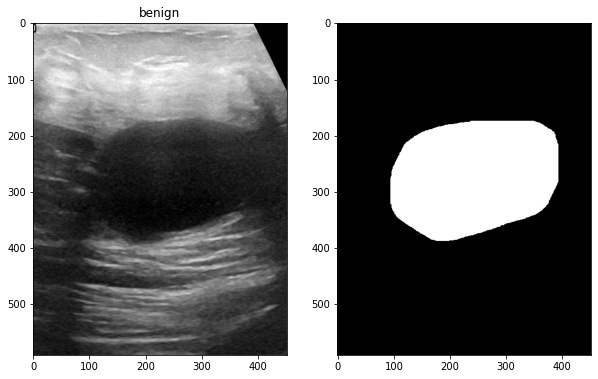

In [ ]:
img = cv2.imread(X_train[0,0])
mask = cv2.imread(X_train[0,1])
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.title(int_to_label.get(y_train[0]))
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask)
plt.show()

In [ ]:
# pretrained model has it's own normalization and resize
# in original paper: only T.RandomHorizontalFlip(0.5), but i do not get it as boxes and masks stay the same
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.ColorJitter(brightness=(0.95, 1.05),
                                            contrast=(0.95, 1.05),
                                            saturation=(0.95, 1.05),
                                            hue=0.0),
                              T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2)),
                              T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                              T.ToTensor()
])

valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.ToTensor()
])

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            torch.save(model.state_dict(), self.path)
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
def get_model(with_mask=False):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if with_mask:
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model.to(device)

In [ ]:
model = get_model(with_mask=True)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
class BreastDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.inputs = X
        self.labels = y
        self.transforms = transforms

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, ix):
        image = cv2.imread(self.inputs[ix, 0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            image = self.transforms(image).to(device).float() / 255

        mask = cv2.imread(self.inputs[ix, 1])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask_ = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(mask_, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            x, y, w, h = cv2.boundingRect((contours[0]))
            if (w <= 10) or (h <= 10):  # to prevent gradients blow up with very small bbs
                w += 10
                h += 10 
            boxes = [x, y, x+w, y+h]
            boxes_ = np.array([boxes])

            area = (boxes_[:, 3] - boxes_[:, 1]) * (boxes_[:, 2] - boxes_[:, 0])

        else:
            boxes = np.arange(4) #otherwise error is raised, alt.:  [0., 0., 20., 20.]
            area = 4.0  # 4. = (2-0)*(3-1) alt.: 400.=(20-0)*(20-0)

        mask_ = torch.as_tensor(mask_[None], dtype=torch.int64).to(device)

        labels = self.labels[ix]

        iscrowd = torch.zeros((1,), dtype=torch.int64)

        image_id = torch.tensor([ix])

        target = {}
        target['masks'] = mask_/255
        target['labels'] = torch.as_tensor([labels], dtype=torch.int64).to(device)
        target['boxes'] = torch.as_tensor([boxes], dtype=torch.float32).to(device)
        target['image_id'] = image_id.to(device)
        target['area'] = torch.as_tensor(area, dtype=torch.float32).to(device)
        target['iscrowd'] = iscrowd.to(device)

        return image, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [ ]:
# testing dataset
ds = BreastDataset(X_train, y_train, train_transforms)

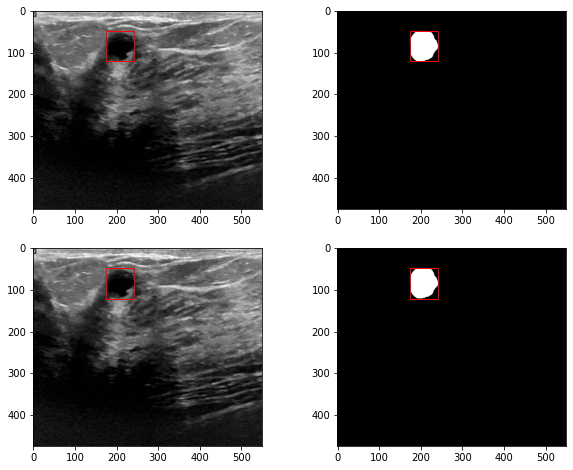

In [ ]:
xmin, ymin, xmax, ymax = ds[9][1]['boxes'].cpu().numpy()[0]

plt.figure(figsize=(10,8))
plt.subplot(221)
img = cv2.imread(X_train[9,0])
plt.imshow(img)
plt.gca().add_patch(Rectangle((175,48),242-175,121-48,linewidth=1,edgecolor='r',facecolor='none'))

plt.subplot(222)
mask = cv2.imread(X_train[9,1])
plt.imshow(mask)
plt.gca().add_patch(Rectangle((175,48),242-175,121-48,linewidth=1,edgecolor='r',facecolor='none'))

plt.subplot(223)
img_ = ds[9][0].permute(1,2,0).cpu().numpy()
plt.imshow(img_)
plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))

plt.subplot(224)
mask_ = ds[9][1]['masks'].permute(1,2,0).cpu().numpy().squeeze()
plt.imshow(mask_, cmap='gray')
plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

In [ ]:
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count
# weight = np.concatenate([[0.001], weight], axis=0)  # comment if 'normal' added # uncomment if using [bg, 1,2]
samples_weight = weight[y_train]
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))
weight
# also can oversample by adding augmented minority images or apply mini-batch SMOTE

array([0.00819672, 0.00251889, 0.0052356 ])

In [ ]:
# skip if not using num_workers

from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
     print('spawn started')
except RuntimeError as exc:
    print(exc)
    pass

context has already been set


In [ ]:
train_ds = BreastDataset(X_train, y_train, train_transforms)
valid_ds = BreastDataset(X_valid, y_valid, valid_transforms)
test_ds = BreastDataset(X_test, y_test, valid_transforms)

#train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn, drop_last=True)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, 
                              collate_fn=train_ds.collate_fn, drop_last=True,)# num_workers=4) # pin_memory=True,)

valid_dataloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

In [ ]:
early_path = r'/content/drive/My Drive/data/model_checkpoint.pth'

params = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, min_lr=1e-6)
early = EarlyStopping(path=early_path)

scaler = torch.cuda.amp.GradScaler()

In [ ]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([i for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    masks = output['masks'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels, masks = [tensor[ixs] for tensor in [bbs, confs, labels, masks]]
    if len(ixs) == 1:
        bbs, confs, labels, masks = [np.array([tensor]) for tensor in [bbs, confs, labels, masks]]
    return bbs, confs, labels, masks

def colour_mask(mask, label):
    colors = [(0,255,0), (0,0,255), (255,0,0)]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    mask[mask>0.5] = 1
    r[mask == 1], g[mask == 1], b[mask == 1] = colors[label]
    col_mask = np.stack([r,g,b], axis=2)
    return col_mask

def train_one_batch(data, model, optimizer, is_scaler=True):
    model.train()
    inputs, target = data

    optimizer.zero_grad()
    #for param in model.parameters():
    #    param.grad = None

    if is_scaler:
        with torch.cuda.amp.autocast():
            losses = model(inputs, target)
            loss = sum(loss for loss in losses.values())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        losses = model(inputs, target)
        loss = sum(loss for loss in losses.values())
        loss.backward()
        optimizer.step()

    return loss, losses

@torch.no_grad()
def validate(data, model, optimizer):
    model.train()
    inputs, target = data

    optimizer.zero_grad()
    losses = model(inputs, target)
    loss = sum(loss for loss in losses.values())

    return loss, losses

In [ ]:
train_losses, valid_losses = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss, _ = train_one_batch(batch, model, optimizer, is_scaler=False)
        batch_train_loss = batch_train_loss.item()
        epoch_train_losses.append(batch_train_loss)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)
    print(f'Train loss: {epoch_train_loss:.4f}')

    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss, _ = validate(batch, model, optimizer)
        batch_valid_loss = batch_valid_loss.item()
        epoch_valid_losses.append(batch_valid_loss)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}')
    print('-'*50)    

    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, model)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        model.load_state_dict(torch.load(early_path))
        break

Epoch 1/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.7794


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.6776
--------------------------------------------------
Epoch 2/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.6518


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.6988
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 3/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.6809


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.6168
--------------------------------------------------
Epoch 4/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.6353


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.5562
--------------------------------------------------
Epoch 5/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.5657


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.5641
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 6/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.5239


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.4984
--------------------------------------------------
Epoch 7/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.4695


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.4427
--------------------------------------------------
Epoch 8/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.4494


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.4401
--------------------------------------------------
Epoch 9/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.4173


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.4212
--------------------------------------------------
Epoch 10/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3905


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.4140
--------------------------------------------------
Epoch 11/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3794


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3874
--------------------------------------------------
Epoch 12/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.4183


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3991
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 13/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3834


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.4049
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 14/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3545


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.4013
--------------------------------------------------
INFO: Early stopping counter 3 of 5
Epoch 15/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3536


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3881
--------------------------------------------------
INFO: Early stopping counter 4 of 5
Epoch 16/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3199


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3608
--------------------------------------------------
Epoch 17/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3107


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3618
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 18/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3156


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3598
--------------------------------------------------
Epoch 19/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3082


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3519
--------------------------------------------------
Epoch 20/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3122


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3610
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 21/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3118


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3482
--------------------------------------------------
Epoch 22/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.2925


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3525
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 23/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.2964


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3577
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 24/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3009


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3546
--------------------------------------------------
INFO: Early stopping counter 3 of 5
Epoch 25/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3115


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3465
--------------------------------------------------
Epoch 26/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.3035


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3529
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 27/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.2773


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3511
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 28/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.2865


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3549
--------------------------------------------------
INFO: Early stopping counter 3 of 5
Epoch 29/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.2816


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3581
--------------------------------------------------
INFO: Early stopping counter 4 of 5
Epoch 30/50


  0%|          | 0/177 [00:00<?, ?it/s]

Train loss: 0.2785


  0%|          | 0/15 [00:00<?, ?it/s]

Valid loss: 0.3516
--------------------------------------------------
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Validation loss did not improve for 5 epochs. Training stopped.


FileNotFoundError: ignored

In [ ]:
#path_entire_model = r'/content/drive/My Drive/data/segm_model.pth'
#path_dict = r'/content/drive/My Drive/data/segm_model_dict.pth'

path_entire_model = r'/content/drive/My Drive/data/segm_model_with_norm.pth'
path_dict = r'/content/drive/My Drive/data/segm_model_dict_with_norm.pth'

In [ ]:
torch.save(model, path_entire_model)
torch.save(model.state_dict(), path_dict)

In [ ]:
model = torch.load(path_entire_model) #, map_location=torch.device('cpu')) # for CPU
# define model first
# model.load_state_dict(torch.load(path_dict))

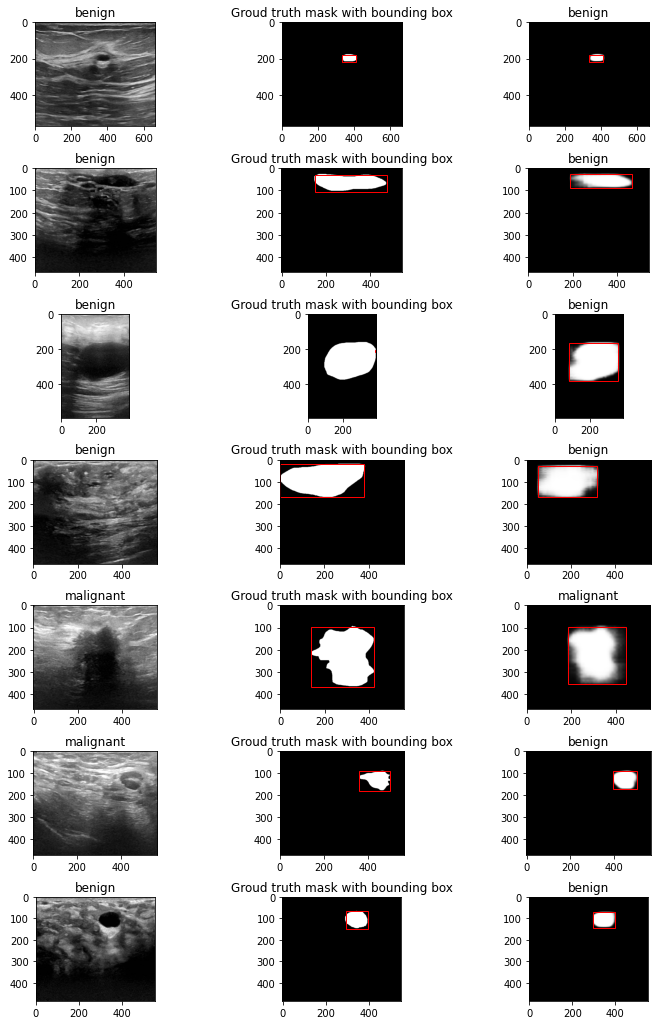

In [ ]:
# inference for model, trained for a few epochs without normal images

model.eval()

plt.figure(figsize=(12, 18))
i = 1
for batch in test_dataloader:
    img, tar = batch
    pred = model(img)
    bbs, confs, labels, masks = decode_output(pred[0])

    plt.subplot(7, 3, i)
    plt.title(int_to_label.get(int(tar[0]['labels'].item())))
    plt.imshow(img[0].permute(1,2,0).cpu().numpy() * 255)

    plt.subplot(7, 3, i+1)
    plt.title('Groud truth mask with bounding box')
    plt.imshow(tar[0]['masks'].permute(1,2,0).cpu().numpy().squeeze(), cmap='gray')
    xmin, ymin, xmax, ymax = tar[0]['boxes'].cpu().numpy().tolist()[0]
    plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))

    plt.subplot(7, 3, i+2)
    plt.title(int_to_label[int(labels[0])])
    mask_ = masks[0].squeeze()
    plt.imshow(mask_, cmap='gray')
    xmin, ymin, xmax, ymax = bbs[0]
    plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))

    i+=3
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Stopped by KeyBoardInterrupt as Colab limitations.

Continue training with lr decay (patience=3) untill early stop: patience = 5

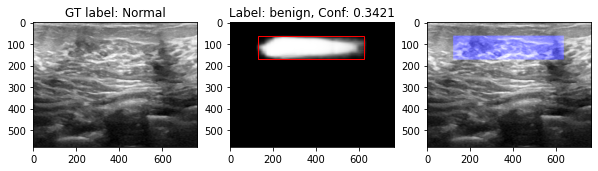

In [ ]:
# load random normal image, using model, trained without normal images
# the model tries to predict bbs and mask for image, even if it is normal (background)
from glob import glob

normal_path = glob('./Dataset_BUSI_with_GT/normal' + '/*')
normal_path = [str(path) for path in normal_path if str(path).endswith(').png')]
idx = np.random.randint(len(normal_path))

image = cv2.imread(str(normal_path[idx]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_ = valid_transforms(image)[None].float() / 255.

model.eval()

output = model(image_)
bbs, confs, labels, masks = decode_output(output[0])

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.title('GT label: Normal')
plt.imshow(image)

plt.subplot(132)
mask_ = masks[0].squeeze()
plt.imshow(mask_, cmap='gray')
if len(bbs[0]) > 0:
    plt.title(f'Label: {int_to_label.get(labels[0])}, Conf: {confs[0]:.4f}')
    xmin, ymin, xmax, ymax = bbs[0]
    plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))
plt.subplot(133)
rgb_mask = colour_mask(mask_, labels[0])
cv2.addWeighted(image, 1, rgb_mask, 0.5, 0, image)
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


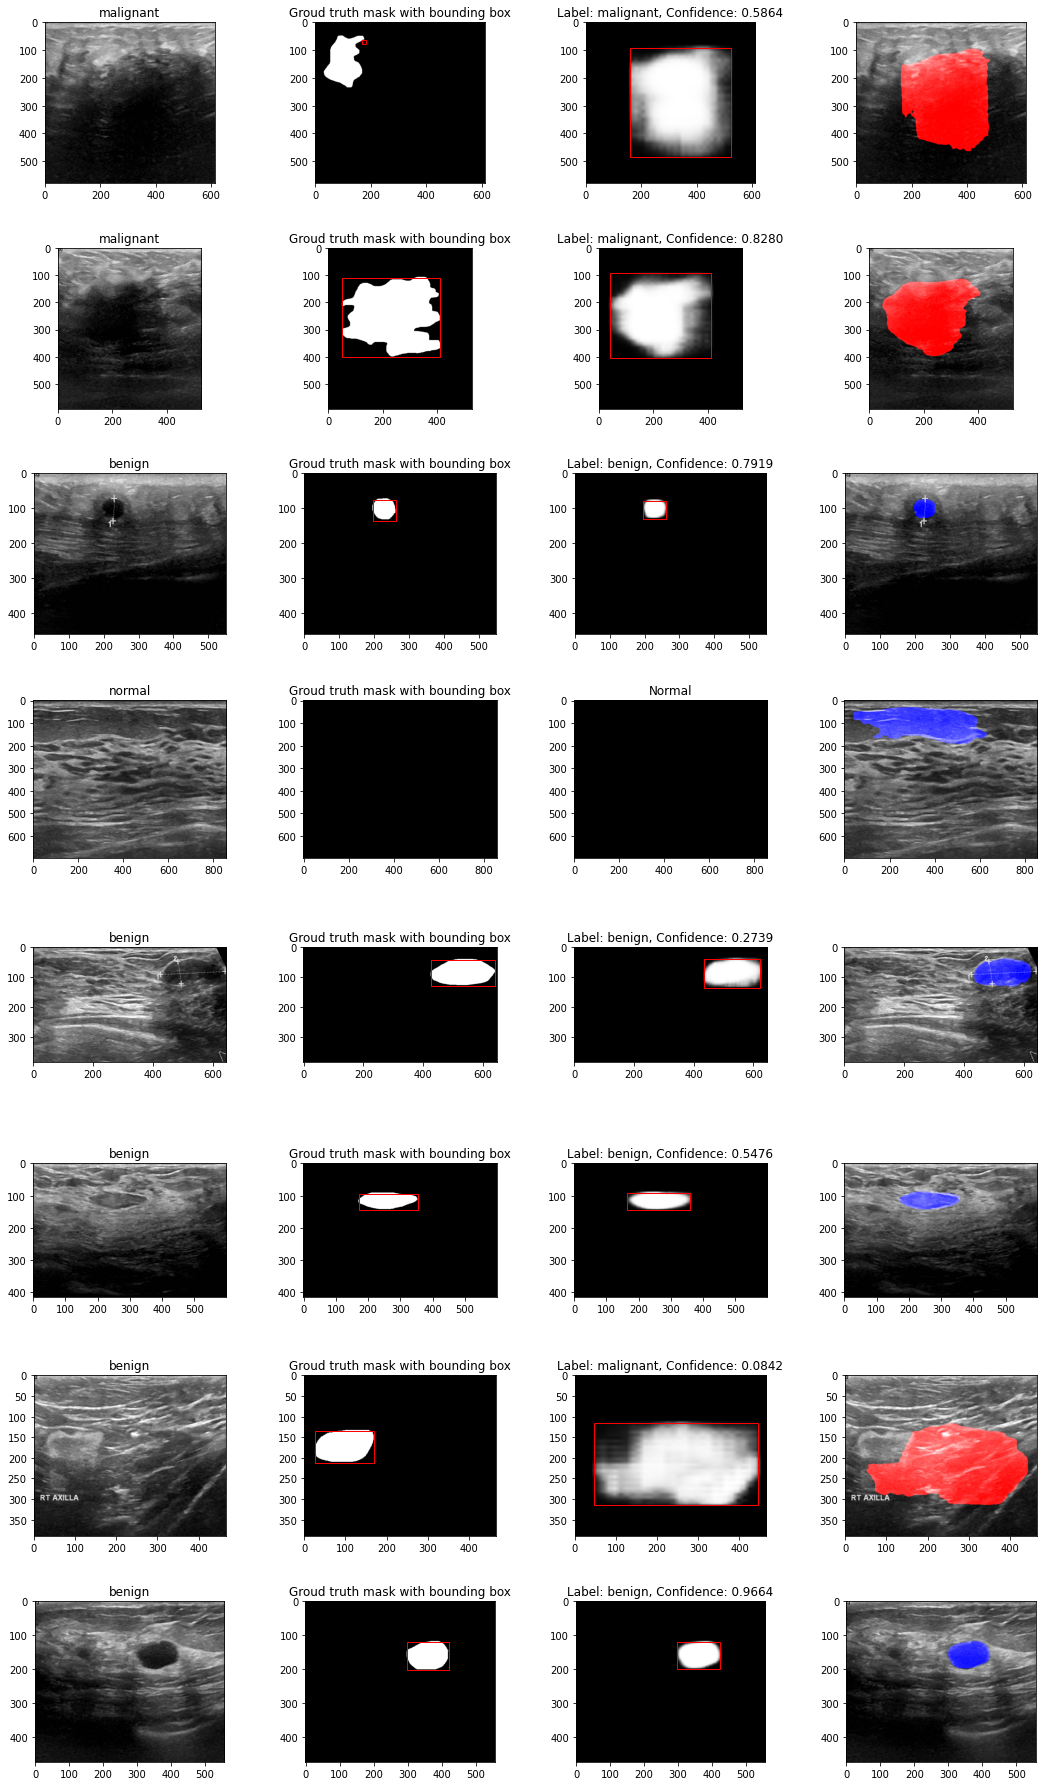

In [ ]:
# inference for model, trained for a few epochs including normal images with bbs = [0,1,2,3]

model.eval()

plt.figure(figsize=(18, 32))
i = 1
for batch in test_dataloader:
    img, tar = batch
    pred = model(img)
    bbs, confs, labels, masks = decode_output(pred[0])

    plt.subplot(8, 4, i)
    plt.title(int_to_label.get(int(tar[0]['labels'].item())))
    image = img[0].permute(1,2,0).cpu().numpy() * 255
    plt.imshow(image)

    plt.subplot(8, 4, i+1)
    plt.title('Groud truth mask with bounding box')
    mask = tar[0]['masks'].permute(1,2,0).cpu().numpy().squeeze()
    plt.imshow(mask, cmap='gray')
    xmin, ymin, xmax, ymax = tar[0]['boxes'][0].cpu().numpy().tolist()
    plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))

    plt.subplot(8, 4, i+2)
    if confs[0] >= 0.06:
        plt.title(f'Label: {int_to_label[int(labels[0])]}, Confidence: {confs[0]:.4f}')
        mask_ = masks[0].squeeze()
        plt.imshow(mask_, cmap='gray')
        xmin, ymin, xmax, ymax = bbs[0]
        plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))
    else:
        plt.title('Normal')
        mask_ = mask
        plt.imshow(mask, cmap='gray')

    plt.subplot(8,4, i+3)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    rgb_mask = colour_mask(masks[0].squeeze(), labels[0])
    cv2.addWeighted(image, 1, rgb_mask, 0.5, 0, image, dtype=cv2.CV_32F)
    plt.imshow(image)

    i+=4
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()